# Estimating Houses prices with Multi-layer Perceptron
## <b>Matheus Silva</b> RA: 140317 <br> <b>Marcos Lucas</b> RA: 140782
### Turma - Integral

In [ ]:
import pandas as pd
import zipfile
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zf = zipfile.ZipFile('/content/drive/MyDrive/2023.1/IA/Data/House_Sale/House_Sale.zip')

data = pd.read_csv(zf.open('kc_house_data.csv')) 

In [ ]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180.0,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170.0,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770.0,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050.0,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680.0,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       2
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [ ]:
# Change the NaN to the average of the values in the same column where they are.
sqft_above_mean = data['sqft_above'].mean()  # I'm doing this because I want to use KFold from sklearn.model_selection 
data['sqft_above'].fillna(sqft_above_mean, inplace=True)
data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [ ]:
# Shuffling the data
data = data.sample(frac=1, random_state=42) # random_state=seed

# Saving the data for future use in the map plot
data_temp = data

In [ ]:
# Removing unnecessary columns to find the best learning model efficiently
data = data.drop(['id', 'date', 'lat', 'long', 'zipcode'], axis=1)

In [ ]:
print(data.columns)

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')


# Let's use Neural Networks to find the price of a house according to their characteristics.

In [ ]:
#@title (a) Adotar protocolo experimental 5-fold crossvalidation, portanto você encontrará 5 melhores RNAs (1 por fold);<br>(b) Encontrar as 5 melhores redes MLP -- h(x), aquelas que melhor se ajustem a f(x) em cada fold para a medida de avaliação (MAPE);<br>(c) Salvar todos os melhores modelos, pois o professor irá utilizá-los para criar o ranking dos grupos. Adotar a nomenclatura "NOME_GRUPO_RNA_FOLD_X.pth", onde X={1,2,3,4,5};
#MULTIPLE LAYER PERCEPTRON
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
import joblib

X = data.drop(['price'], axis=1)  # 15 attributes
y = data['price']

# Normalizing the data
X_norm = (X - X.min()) / (X.max() - X.min())
y_norm = (y - y.min()) / (y.max() - y.min())

# Creating the MLPRegressor
'''
# best until now
hidden_layer_sizes=(15, 50, 35, 15, 5, 5) ótimo 24%
hidden_layer_sizes=(25, 100, 200, 25, 5) de longe o melhor 23%
hidden_layer_sizes=(25, 100, 200, 50, 10)
'''

mlp = MLPRegressor(hidden_layer_sizes=(25, 50, 100, 50, 10),  # Number and size of intermediate layers
                   activation='relu',  # ReLU activation function
                   solver='adam',  # Optimization algorithm
                   alpha=0.0001, # L2 regularization parameter
                   max_iter=500)

# Using KFold for 5-fold cross-validation
kf = KFold(n_splits=5)
mape_scores = []  # List to store MAPE scores
mae_scores = [] # List to store MAE scores
mse_scores = [] # List to store MSE scores
rmse_scores = [] # List to store RMSE scores
mlp_diff_series = pd.Series(index=y.index, dtype='float64') # Series to store diff = abs(y - h(x))
mlp_pred_series = pd.Series(index=y.index, dtype='float64') # Series to store predections
fold_idx_list = [] # List to store the index of each fold 1-5
for fold, (train_index, test_index) in enumerate(kf.split(X)):
  print(f'Fold #{fold + 1}')

  
  # Splitting data
  X_train, X_test = X_norm.loc[train_index], X_norm.loc[test_index]  
  y_train, y_test = y_norm[train_index], y_norm[test_index]


  mlp.fit(X_train, y_train)  # Training MLPRegressor
  y_pred = mlp.predict(X_test)  # Predicting house prices on test set
  
  # Reverse normalizing of the y_test and y_pred
  y_test = (y_test * (y[test_index].max() - y[test_index].min())) + y[test_index].min()
  y_pred = (y_pred * (y[test_index].max() - y[test_index].min())) + y[test_index].min()

  
  mlp_diff_series[test_index] = abs(y_test - y_pred)
  mlp_pred_series.loc[test_index] = y_pred
  fold_idx_list.append(test_index)
  
  mape = mean_absolute_percentage_error(y_test, y_pred)  # Calculating MAPE
  mae = mean_absolute_error(y_test, y_pred) # Calculating MAE
  mse = mean_squared_error(y_test, y_pred) # Calculating MSE
  rmse = np.sqrt(mean_absolute_error(y_test, y_pred)) # Calculating RMSE

  # Storing scores
  mape_scores.append(mape)  
  mae_scores.append(mae)
  mse_scores.append(mse)
  rmse_scores.append(rmse)

  # Printing MAPE scores for each fold
  print(f'MAPE: {mape}')
  print(f'MAE: {mae}')
  print(f'MSE: {mse}')
  print(f'RMSE: {rmse}\n')

  joblib.dump(mlp, f'MatheusSilva_MarcosLucas_RNA_FOLD_{fold+1}.pkl') # Saving models with joblib.dump. Use joblib.load() to load the model

print("Average MAPE score: ", np.mean(mape_scores)) 
print("Average MAE score: ", np.mean(mae_scores)) 
print("Average MSE score: ", np.mean(mse_scores)) 
print("Average RMSE score: ", np.mean(rmse_scores))

Fold #1
MAPE: 0.2565147666543448
MAE: 115914.2720870057
MSE: 32241007830.724895
RMSE: 340.4618511478279

Fold #2
MAPE: 0.24556764120156577
MAE: 122501.15776344402
MSE: 35684836454.50583
RMSE: 350.00165394386926

Fold #3
MAPE: 0.23328371642396617
MAE: 105409.07926988305
MSE: 25567076857.086506
RMSE: 324.667644322441

Fold #4
MAPE: 0.20122344980410564
MAE: 59103.66860200337
MSE: 7729521219.436919
RMSE: 243.1124608118707

Fold #5
MAPE: 0.19907921385395777
MAE: 63251.04018289904
MSE: 9706929901.304022
RMSE: 251.49759478551488

Average MAPE score:  0.22713375758758803
Average MAE score:  93235.84358104704
Average MSE score:  22185874452.611633
Average RMSE score:  301.9482410023047


To load .pkl model use:

```
import joblib

model = joblib.load('MatheusSilva_MarcosLucas_RNA_FOLD_X.pkl') # X -> Fold
```
Using loaded model:
```
X_norm = (X - X.min()) / (X.max() - X.min()) # normalizing attributes
y_pred = model.predict(X_norm)
y_pred = (y_pred * (y.max() - y.min())) + y.min() # reverse normalizing price
mape = mean_absolute_percentage_error(y, y_pred))

print(mape)
```



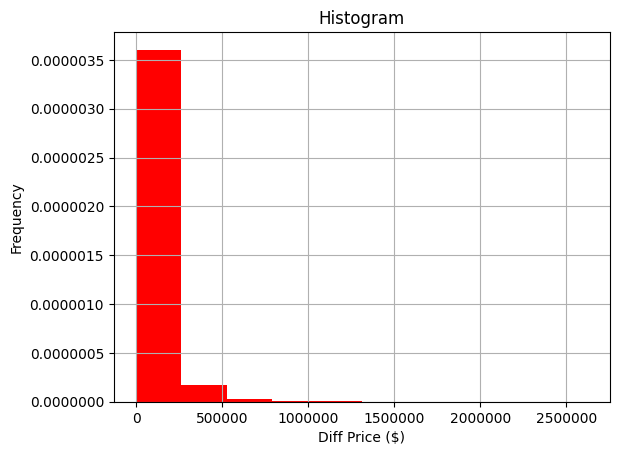

In [ ]:
#@title (d) Calcular a diff = abs(y - h(x)) e plotar igual aula prática II;
import matplotlib.pyplot as plt

# I already calculate the diff previously 
# Let's plot

n, bins, patches = plt.hist(mlp_diff_series, density=True, color='red')

plt.xlabel('Diff Price ($)')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.ticklabel_format(style='plain')
plt.grid(True)
plt.show()

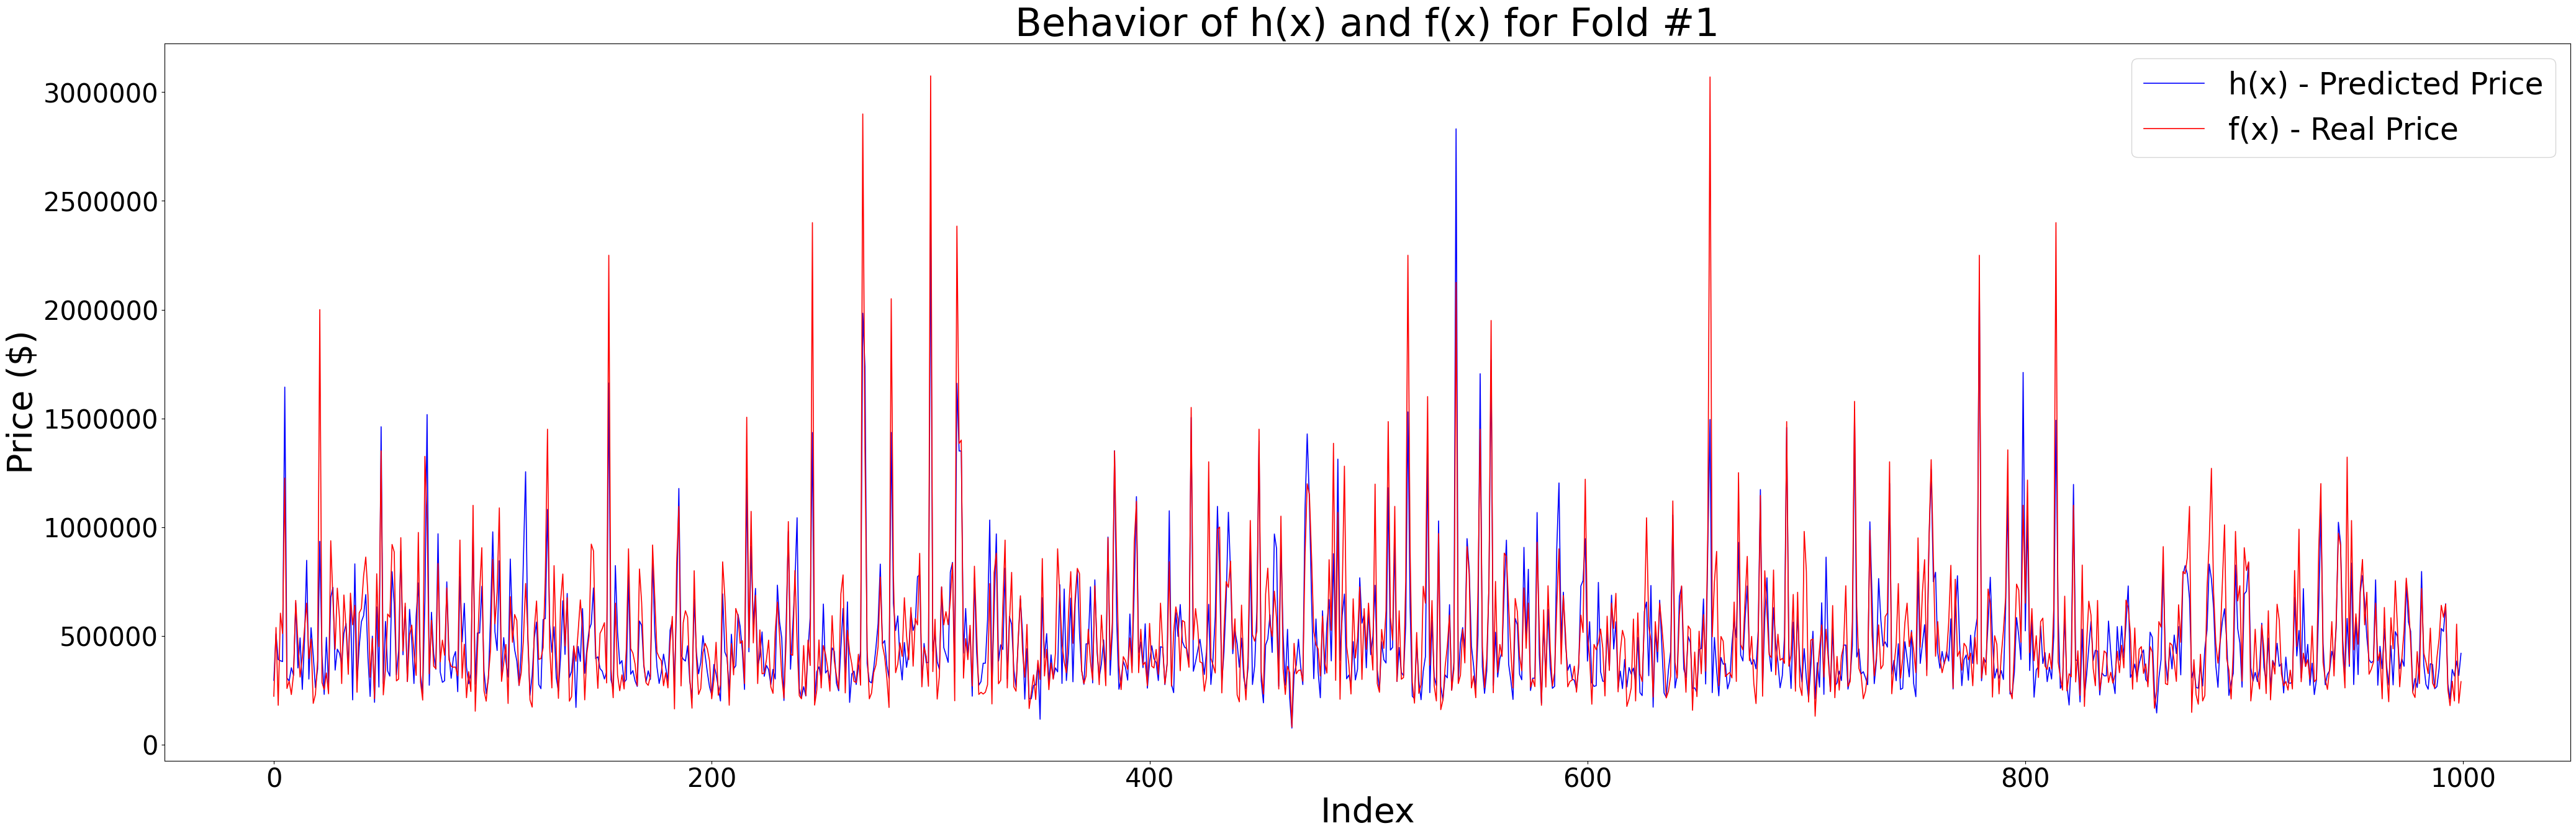

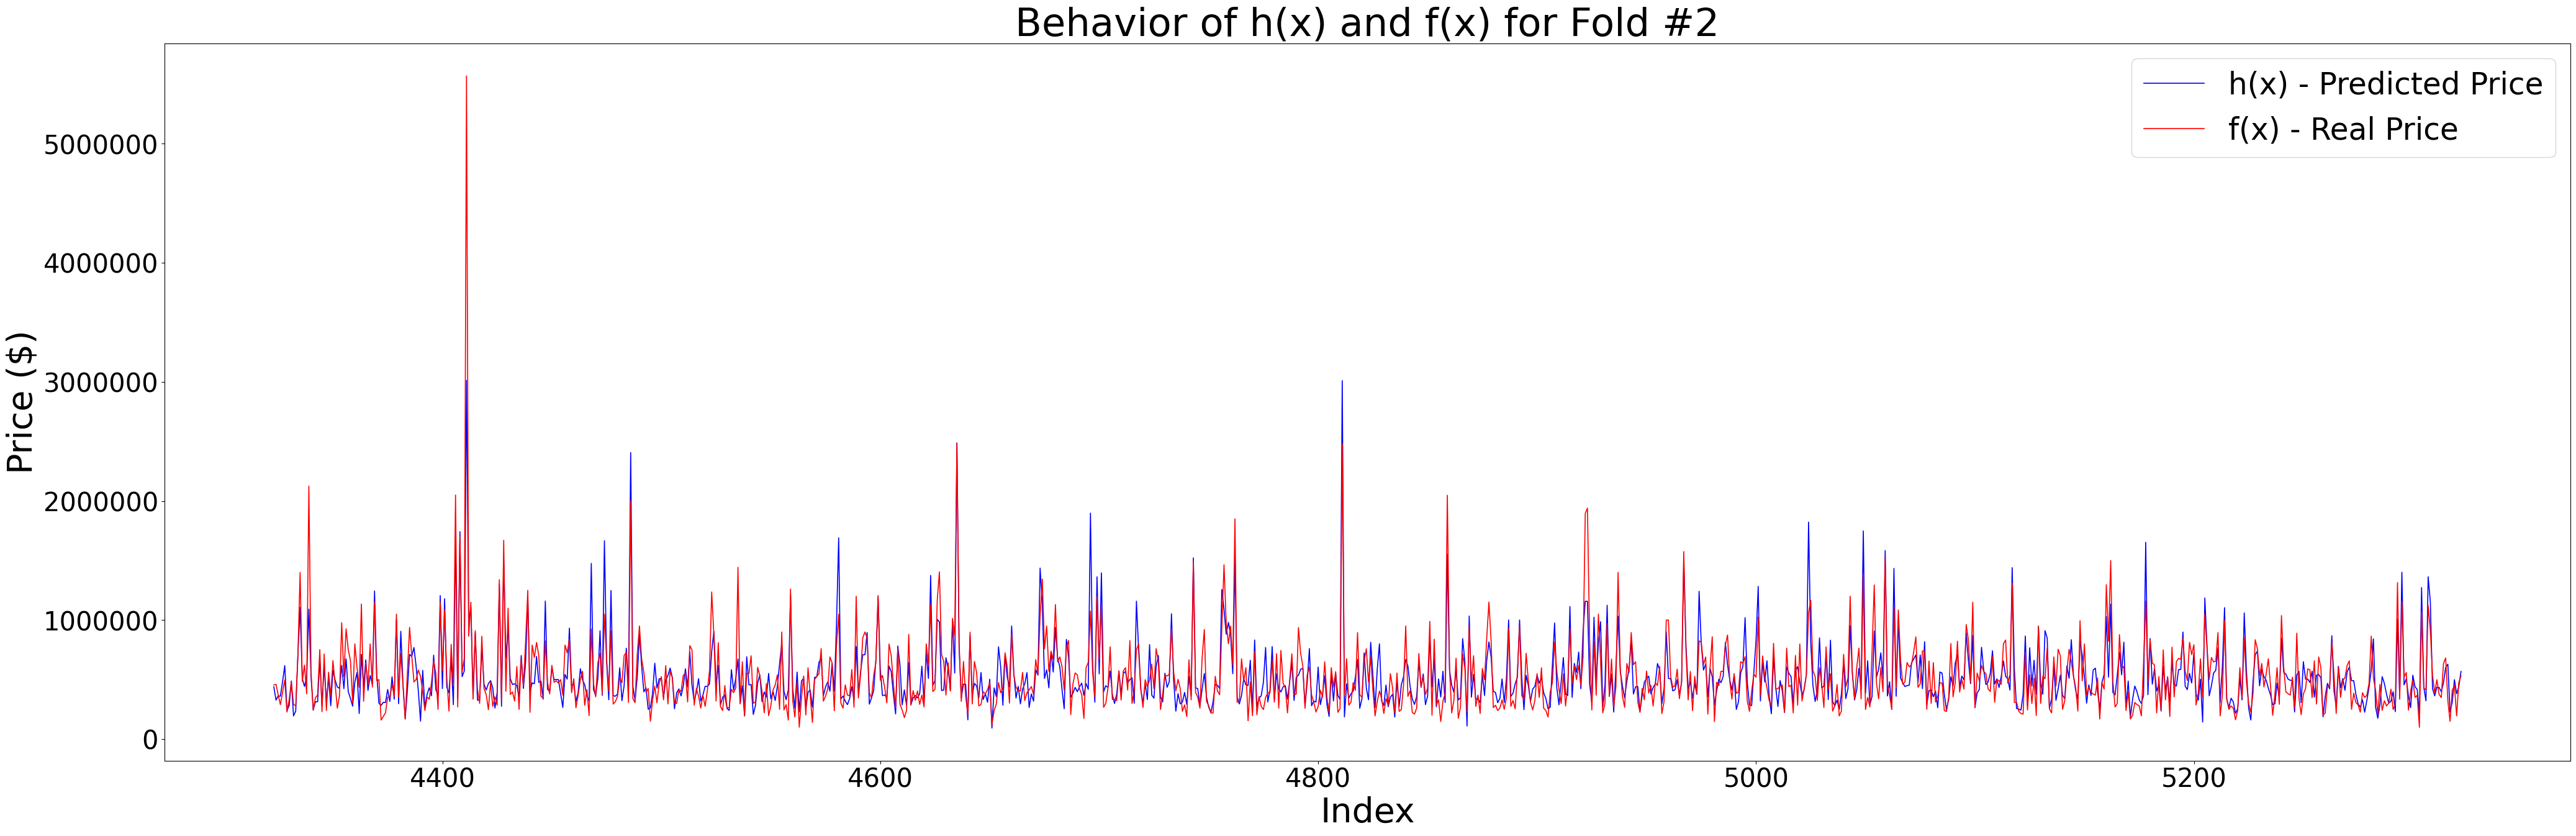

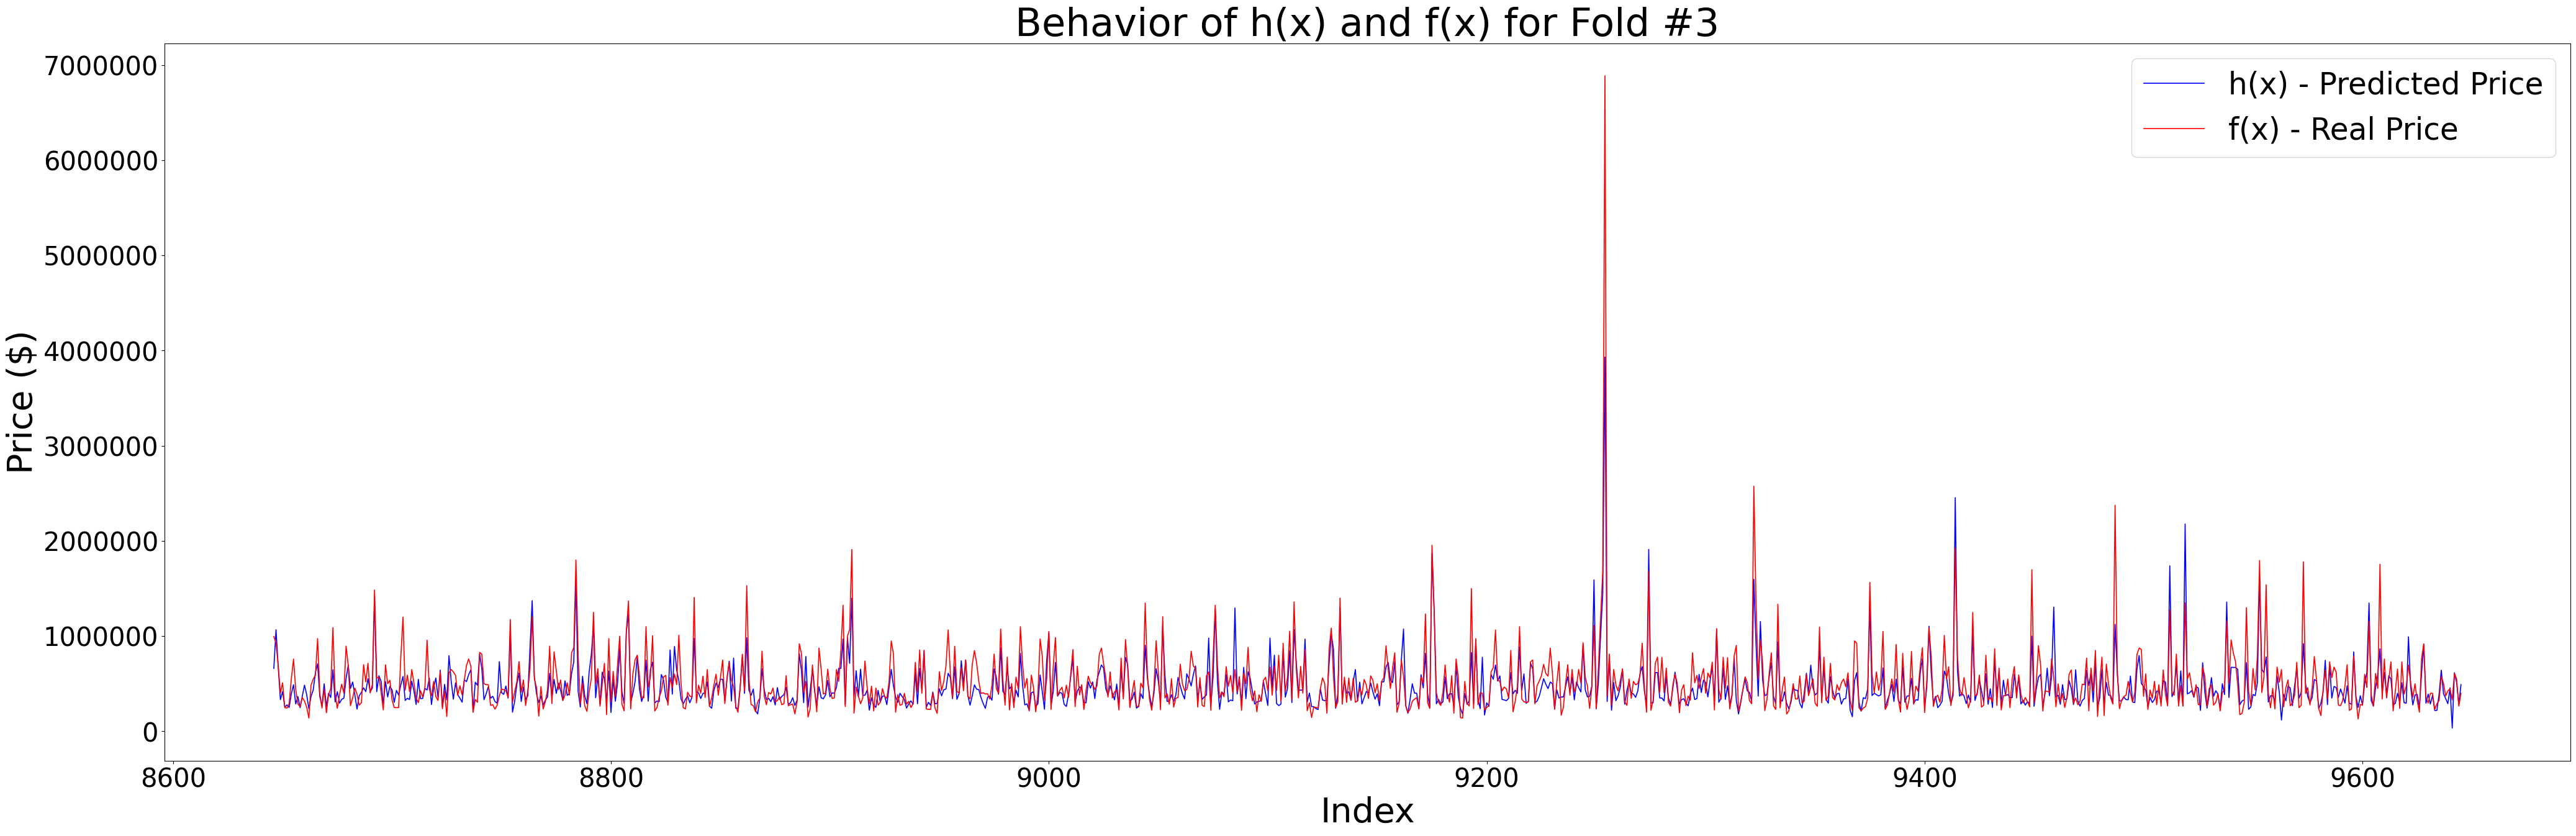

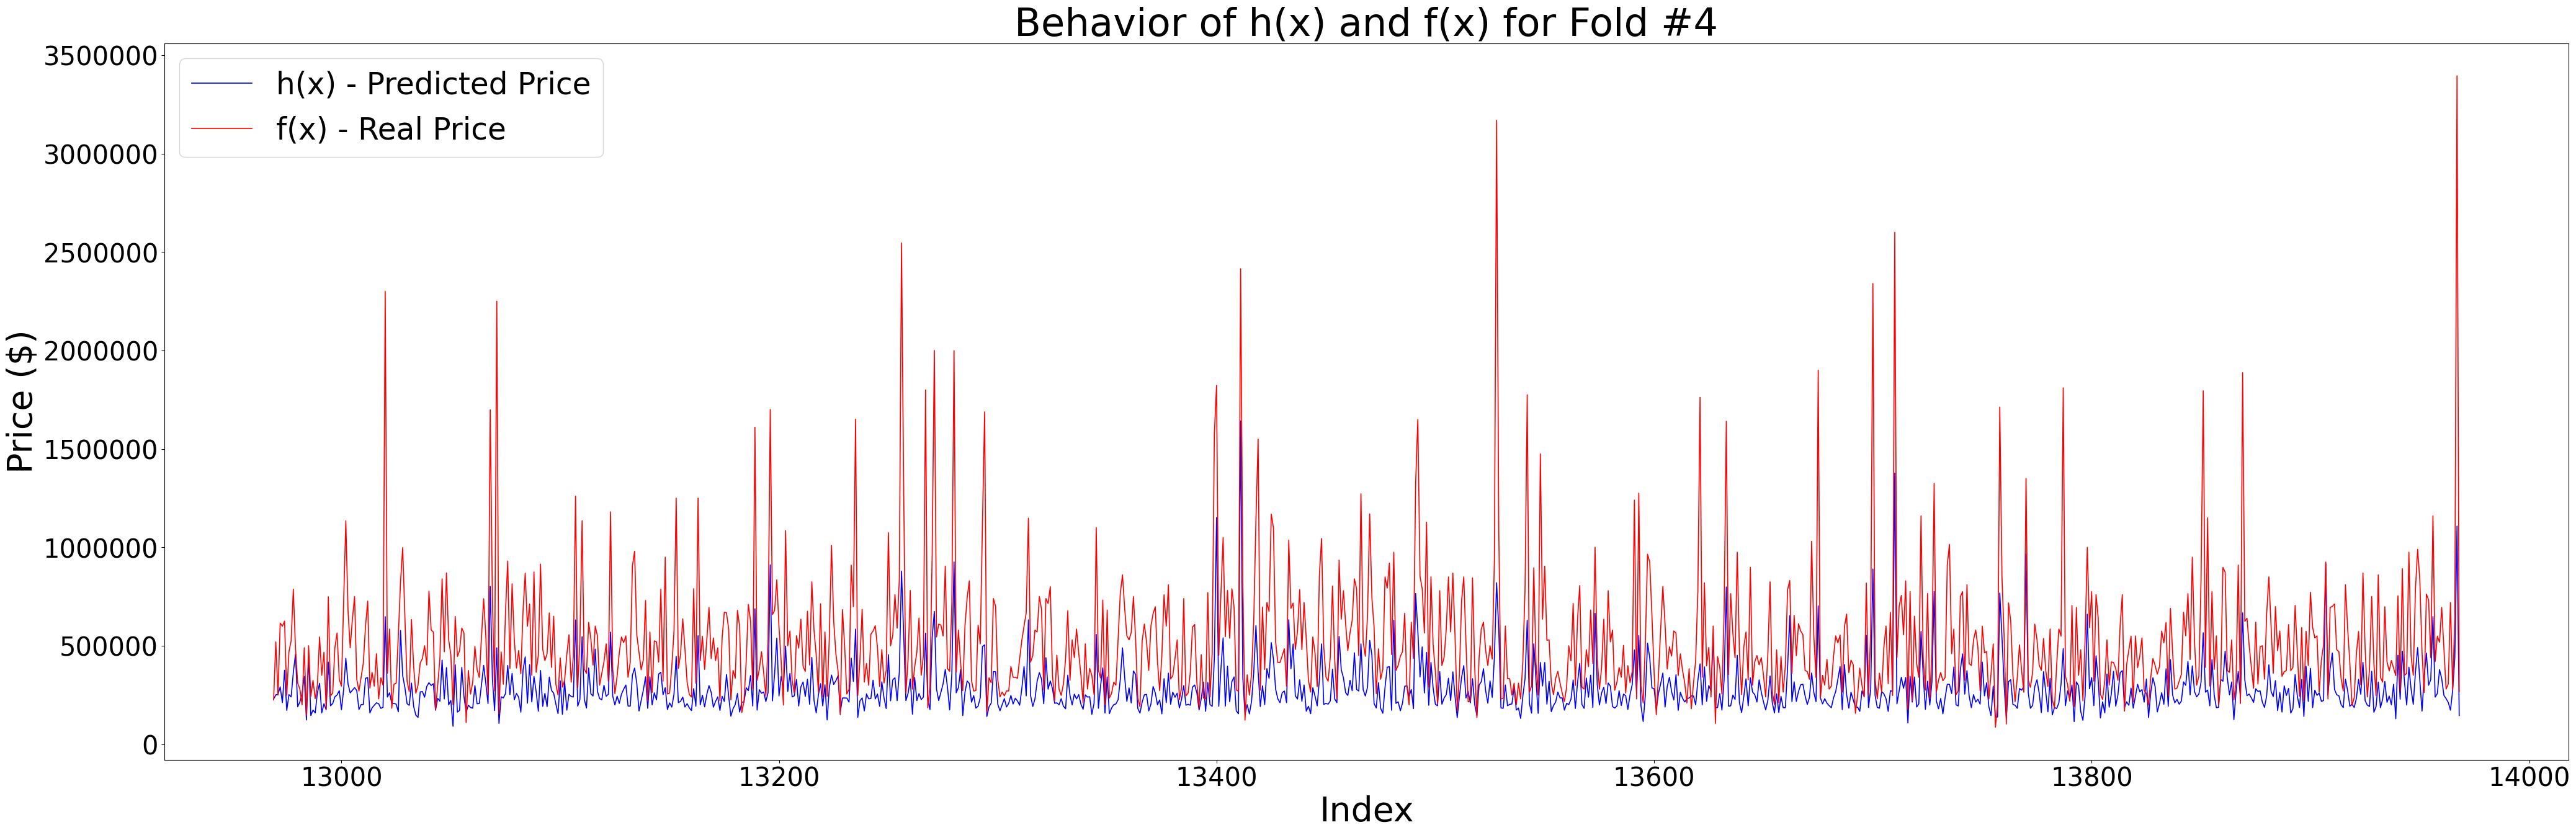

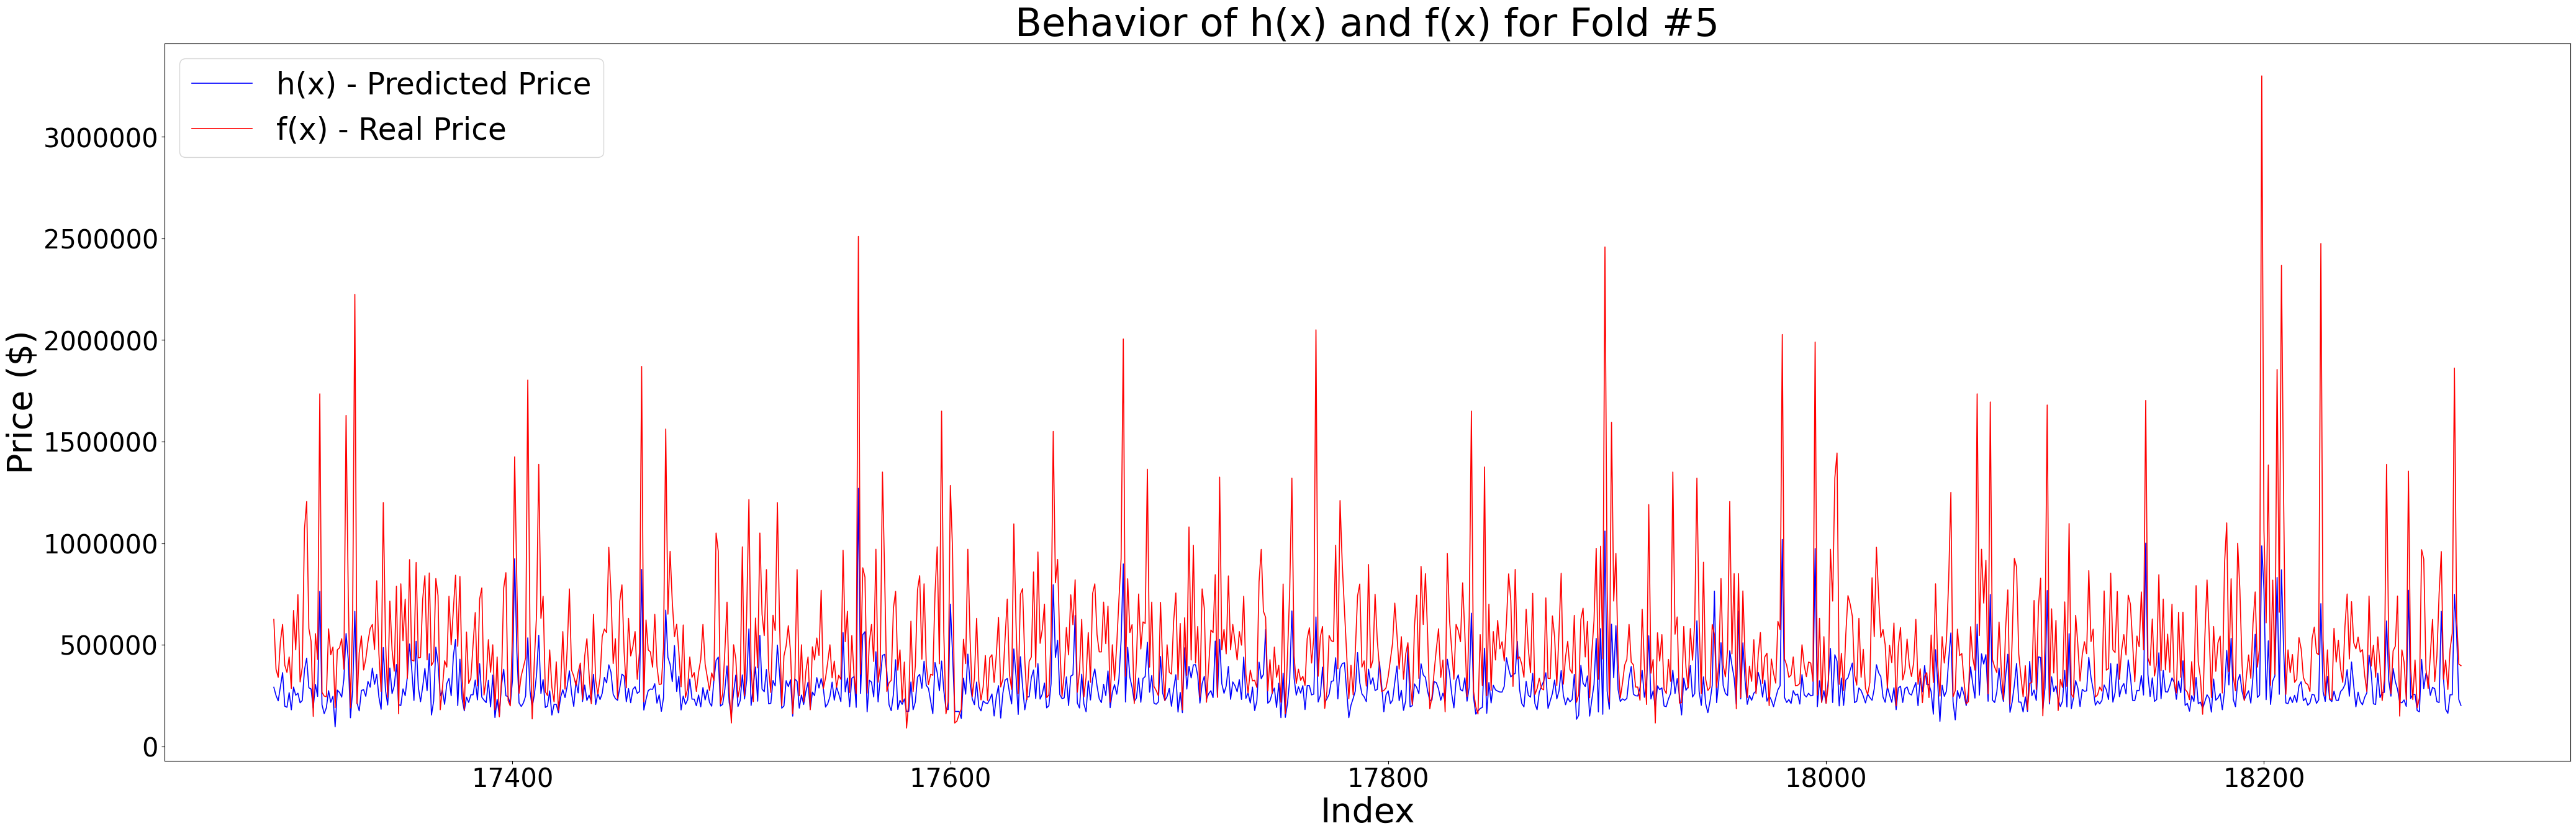

In [ ]:
#@title (e) Plotar o gráfico de linhas para todas as amostras, mostrando o comportamento de h(x) e f(x);

# Loop to plot the curves for each fold on a separate plot
for fold in range(5):
    fig, ax = plt.subplots(figsize=(50, 15))  # Create a new figure and axis for each fold

    idx = fold_idx_list[fold]
    # Selecting only the data of the fold
    fx = y[idx].values
    hx = mlp_pred_series[idx].values

    ax.plot(idx[:1000], hx[:1000], label='h(x) - Predicted Price', color='blue', linewidth=1.2)
    ax.plot(idx[:1000], fx[:1000], label='f(x) - Real Price', color='red', linewidth=1.2)

    ax.set_xlabel('Index', fontsize=40)
    ax.set_ylabel('Price ($)', fontsize=40)
    ax.set_title(f'Behavior of h(x) and f(x) for Fold #{fold+1}', fontsize=45)
    ax.legend(fontsize=35)  # Add legend with line labels to the current plot

    ax.ticklabel_format(useOffset=False, style='plain')
    ax.tick_params(axis='both', which='both', labelsize=30)  # Set fontsize for tick labels

    # Adjust spacing between subplots
    #plt.subplots_adjust(hspace=4)  # Use hspace to adjust vertical spacing between subplots
    # Show the plot
    plt.show()


In [ ]:
#@title (f) Adicionar uma nova coluna na planilha dos dados com o nome de NEW PRICE com os valores estimados pela melhor h(x) encontrada.
data = data_temp # data_temp contains excluded columns, like lat, long, id, zipcode... 
data['new_price'] = mlp_pred_series

# Add diff column to use with HeatMap to plot the map
data['diff'] = mlp_diff_series

In [ ]:
from datetime import datetime

# Function to format data into a popup html
def format_popup(data):
  data_datetime = datetime.strptime(data[1], "%Y%m%dT%H%M%S")
  formated_date = data_datetime.strftime("%m/%d/%Y")
  formated_price = "${:,.2f}".format(data[2])
  formated_new_price = "${:,.2f}".format(data['new_price'])
  formated_diff = "{:,.2f}".format(data['diff'])
  popup_string = f"<b>ID:</b> {data[0]}<br>"
  popup_string += f"<b>Date:</b> {formated_date}<br>"
  popup_string += f"<b>Price:</b> {formated_price}<br>"
  popup_string += f"<b>New Price:</b> <span style=\"color:DodgerBlue;\">{formated_new_price}</span><br>"
  popup_string += f"<b>Bedrooms:</b> {data[3]}<br>"
  popup_string += f"<b>Bathrooms:</b> {data[4]}<br>"
  popup_string += f"<b>Sqft Living:</b> {data[5]}<br>"
  popup_string += f"<b>Sqft Lot:</b> {data[6]}<br>"
  popup_string += f"<b>Floors:</b> {data[7]}<br>"
  popup_string += f"<b>Waterfront:</b> {data[8]}<br>"
  popup_string += f"<b>View:</b> {data[9]}<br>"
  popup_string += f"<b>Condition:</b> {data[10]}<br>"
  popup_string += f"<b>Grade:</b> {data[11]}<br>"
  popup_string += f"<b>Sqft Above:</b> {data[12]}<br>"
  popup_string += f"<b>Sqft Basement:</b> {data[13]}<br>"
  popup_string += f"<b>Year Built:</b> {data[14]}<br>"
  popup_string += f"<b>Year Renovated:</b> {data[15]}<br>"
  popup_string += f"<b>ZIP Code:</b> {data[16]}<br>"
  popup_string += f"<b>Lat:</b> {data[17]}<br>"
  popup_string += f"<b>Lon:</b> {data[18]}<br>"
  popup_string += f"<b>Sqft Living15:</b> {data[19]}<br>"
  popup_string += f"<b>Sqft Lot15:</b> {data[20]}<br>"
  popup_string += f"<b>Diff:</b> {formated_diff}<br>"
  return popup_string

In [ ]:
import folium
from folium.plugins import MarkerCluster, HeatMap

# Initialize map object
mapObj = folium.Map(location=[47.60323, -122], 
                    zoom_start=9,
                    tiles='Stamen Terrain')

# Add a tile layer
folium.TileLayer('OpenStreetMap',
            attr='OpenStreetMap',
            name='Open Street Map').add_to(mapObj)

# Create a list of locations
locations = list(zip(data['lat'], data['long']))

# Create a HeatMap layer from mlp_diff_series
heatmap_layer = HeatMap(list(zip(data['lat'], data['long'], data['diff'])),
                        name = 'Heat Map (Diff)',
                        min_opacity=0.2,
                        radius=15, blur=25)

# Add heatmap layer to the map
heatmap_layer.add_to(mapObj)

marker_cluster = MarkerCluster(name='House Markers', disable_cluster_at_zoom=10)

# Create colunm with data formated to html
data['popup_string'] = data.apply(format_popup, axis=1)
popups = list(data['popup_string'])

# Add markers to the MarkerCluster
for location, popup in zip(locations, popups):
  folium.Marker(
    location=location,
    popup=folium.Popup(popup, max_width=250), # Use the formatted popup string,
    icon=folium.Icon(icon="home")
  ).add_to(marker_cluster)



bordersStyle = {
  'weight': 3,
  'opacity': 0.8,
  'fillOpacity': 0.1
}


# Add Highlighted King County
folium.GeoJson(
    '/content/drive/MyDrive/2023.1/IA/Data/king_county.geojson', 
    name="King County",
    style_function=lambda x:bordersStyle
    ).add_to(mapObj)


# Add heatmap layer to the map
heatmap_layer.add_to(mapObj)

# Add the MarkerCluster to the map
marker_cluster.add_to(mapObj)

# Add Layer Control to the map
folium.LayerControl().add_to(mapObj)

# Save the map to an HTML file
mapObj.save('map.html')

# Display on Screen
mapObj

In [ ]:
#DECISION TREE REGRESSOR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Removing unnecessary columns to find the best learning model efficiently
data = data.drop(['id', 'date', 'lat', 'long', 'zipcode', 'popup_string'], axis=1)

X = data.drop(['price'], axis=1)  # 15 attributes
y = data['price']
# Creating the Decision Tree
dtree = DecisionTreeRegressor(random_state=5, max_depth=10)  

# Using KFold for 5-fold cross-validation
kf = KFold(n_splits=5)
dtree_mape_scores = []  # List to store MAPE scores
dtree_mae_scores = []  # List to store MAE scores
dtree_mse_scores = []  # List to store MSE scores
dtree_rmse_scores = []  # List to store RMSE scores
for fold, (train_index, test_index) in enumerate(kf.split(X)):
  print(f'Fold #{fold + 1}')
  X_train, X_test = X.loc[train_index], X.loc[test_index]  # Splitting data
  y_train, y_test = y[train_index], y[test_index]
  
  dtree.fit(X_train, y_train)  # Training Decision Tree
  y_pred = dtree.predict(X_test)  # Predicting house prices on test set
  
  dtree_mape = mean_absolute_percentage_error(y_test, y_pred)  # Calculating MAPE
  dtree_mae = mean_absolute_error(y_test, y_pred) # Calculating MAE
  dtree_mse = mean_squared_error(y_test, y_pred) # Calculating MSE
  dtree_rmse = np.sqrt(mean_absolute_error(y_test, y_pred)) # Calculating RMSE

  print(f'MAPE: {dtree_mape}')
  print(f'MAE: {dtree_mae}')
  print(f'MSE: {dtree_mse}')
  print(f'RMSE: {dtree_rmse}\n')

  dtree_mape_scores.append(dtree_mape)
  dtree_mae_scores.append(dtree_mae)
  dtree_mse_scores.append(dtree_mse)
  dtree_rmse_scores.append(dtree_rmse)

print("Average MAPE score: ", np.mean(dtree_mape_scores)) 
print("Average MAE score: ", np.mean(dtree_mae_scores)) 
print("Average MSE score: ", np.mean(dtree_mse_scores)) 
print("Average RMSE score: ", np.mean(dtree_rmse_scores))

Fold #1
MAPE: 0.26274416248285776
MAE: 123921.41658031722
MSE: 51303599272.27414
RMSE: 352.0247385913627

Fold #2
MAPE: 0.277095743310617
MAE: 128679.39773834204
MSE: 64707461796.6305
RMSE: 358.7191070159799

Fold #3
MAPE: 0.25178659997912806
MAE: 115990.4491753232
MSE: 43145968851.60248
RMSE: 340.5737059365024

Fold #4
MAPE: 0.25693481717304806
MAE: 132618.28576662208
MSE: 46091379765.03833
RMSE: 364.16793621435437

Fold #5
MAPE: 0.24279666855788906
MAE: 131083.20488399058
MSE: 45795248226.311676
RMSE: 362.05414634276815

Average MAPE score:  0.258271598300708
Average MAE score:  126458.55082891902
Average MSE score:  50208731582.37142
Average RMSE score:  355.50792682019346


In [ ]:
#LINEAR REGRESSION
from sklearn.linear_model import LinearRegression

X = data.drop(['price'], axis=1)  # 15 attributes
y = data['price']

# Creating the Linear Regression
lnreg = LinearRegression(fit_intercept=True)

# Using KFold for 5-fold cross-validation
kf = KFold(n_splits=5)
lnreg_mape_scores = []  # List to store MAPE scores
lnreg_mae_scores = []  # List to store MAE scores
lnreg_mse_scores = []  # List to store MSE scores
lnreg_rmse_scores = []  # List to store RMSE scores
for fold, (train_index, test_index) in enumerate(kf.split(X)):
  print(f'Fold #{fold + 1}')
  X_train, X_test = X.loc[train_index], X.loc[test_index]  # Splitting data
  y_train, y_test = y[train_index], y[test_index]
  
  lnreg.fit(X_train, y_train)  # Training Linear Regression
  y_pred = lnreg.predict(X_test)  # Predicting house prices on test set
  
  lnreg_mape = mean_absolute_percentage_error(y_test, y_pred)  # Calculating MAPE
  lnreg_mae = mean_absolute_error(y_test, y_pred) # Calculating MAE
  lnreg_mse = mean_squared_error(y_test, y_pred) # Calculating MSE
  lnreg_rmse = np.sqrt(mean_absolute_error(y_test, y_pred)) # Calculating RMSE

  print(f'MAPE: {lnreg_mape}')
  print(f'MAE: {lnreg_mae}')
  print(f'MSE: {lnreg_mse}')
  print(f'RMSE: {lnreg_rmse}\n')

  lnreg_mape_scores.append(dtree_mape)
  lnreg_mae_scores.append(dtree_mae)
  lnreg_mse_scores.append(dtree_mse)
  lnreg_rmse_scores.append(dtree_rmse)

print("Average MAPE score: ", np.mean(lnreg_mape_scores)) 
print("Average MAE score: ", np.mean(lnreg_mae_scores)) 
print("Average MSE score: ", np.mean(lnreg_mse_scores)) 
print("Average RMSE score: ", np.mean(lnreg_rmse_scores))

Fold #1
MAPE: 0.3132578778416857
MAE: 131097.30434070667
MSE: 43643848402.381256
RMSE: 362.073617294476

Fold #2
MAPE: 0.30382447455416367
MAE: 123024.60085222797
MSE: 39346768659.09555
RMSE: 350.74862915231466

Fold #3
MAPE: 0.29063020953506963
MAE: 119145.43731473351
MSE: 35195741939.869576
RMSE: 345.17450270078393

Fold #4
MAPE: 0.2755128606394371
MAE: 139518.13193584766
MSE: 39767106148.11693
RMSE: 373.52126035320623

Fold #5
MAPE: 0.27255551786264587
MAE: 152036.39886639957
MSE: 49337310952.4385
RMSE: 389.91845155929667

Average MAPE score:  0.24279666855788906
Average MAE score:  131083.20488399058
Average MSE score:  45795248226.311676
Average RMSE score:  362.05414634276815


In [ ]:
!pip install prettytable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
mlp_mape = round(np.mean(mape_scores), 2)
mlp_mae = round(np.mean(mae_scores), 2)
mlp_mse = round(np.mean(mse_scores), 2)
mlp_rmse = round(np.mean(rmse_scores), 2)

dtree_mape = round(np.mean(dtree_mape_scores), 2)
dtree_mae = round(np.mean(dtree_mae_scores), 2)
dtree_mse = round(np.mean(dtree_mse_scores), 2)
dtree_rmse = round(np.mean(dtree_rmse_scores), 2)

lnreg_mape = round(np.mean(lnreg_mape_scores), 2)
lnreg_mae = round(np.mean(lnreg_mae_scores), 2)
lnreg_mse = round(np.mean(lnreg_mse_scores), 2)
lnreg_rmse = round(np.mean(lnreg_rmse_scores), 2)

# Tabela de comparação entre os modelos

In [ ]:
from prettytable import PrettyTable

columns = ('Model', 'MAPE', 'MAE', 'MSE', 'RMSE')
myTable = PrettyTable()

myTable.add_column(columns[0], ['Neural Network', 'Decision Tree Regressor', 'Linear Regression'])
myTable.add_column(columns[1], [mlp_mape, dtree_mape, lnreg_mape])
myTable.add_column(columns[2], [mlp_mae, dtree_mae, lnreg_mae])
myTable.add_column(columns[3], [mlp_mse, dtree_mse, lnreg_mse])
myTable.add_column(columns[4], [mlp_rmse, dtree_rmse, lnreg_rmse])

print(myTable)

+-------------------------+------+-----------+----------------+--------+
|          Model          | MAPE |    MAE    |      MSE       |  RMSE  |
+-------------------------+------+-----------+----------------+--------+
|      Neural Network     | 0.23 |  93235.84 | 22185874452.61 | 301.95 |
| Decision Tree Regressor | 0.26 | 126458.55 | 50208731582.37 | 355.51 |
|    Linear Regression    | 0.24 |  131083.2 | 45795248226.31 | 362.05 |
+-------------------------+------+-----------+----------------+--------+
